# Fit of `B0_M` with the real data
- no cut on `BDT` for now
- cut on $\Delta M$ : $143\ MeV < \Delta M < 148\ MeV$
- We will fit the part: $5050\ MeV< B0\_M < 5550\ MeV$

## Libraries

In [2]:
import numpy as np
import zfit
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#Gives us nice LaTeX fonts in the plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit

Welcome to JupyROOT 6.22/02


## Load files

In [3]:
with open(f'{loc.JSON}/MC_params.json', 'r') as f:
    MC_param_results = json.load(f)

In [5]:
df_data_strip = fct.load_data(years, magnets, type_data='data_strip', vars=['B0_M','tau_M', 'BDT'],
                            cut_DeltaM=True)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//stripped/data/data_90000000_2016_down.root


## Fitting - first try
- One exponential component
- One CB (Crystall ball PDF)

In [4]:
low = 5050.
high = 5550.
obs = zfit.Space("x", limits=(low, high))

In [5]:
mu1 = zfit.Parameter("mu1", MC_param_results['mu_MC'], 5275., 5285.)
sigma1 = zfit.Parameter("sigma1", 20., 10., 30.)
alphaL1 = zfit.Parameter("alphaL1", MC_param_results['alphaL_MC'], floating=False)
alphaR1 = zfit.Parameter("alphaR1", MC_param_results['alphaR_MC'], floating=False)
nL1 = zfit.Parameter("nL1", MC_param_results['nL_MC'], floating=False)
nR1 = zfit.Parameter("nR1", MC_param_results['nR_MC'], floating=False)

In [6]:
n_bkg1 = zfit.Parameter('n_bkg1', len(df_data_strip)*8/10,0,len(df_data_strip))
n_sig1 = zfit.Parameter('n_sig1', len(df_data_strip)*2/10,0,len(df_data_strip))

In [7]:
lambd1 = zfit.Parameter("lambda1", -0.06, -1, -0.0001)

In [14]:
name_params1 ={
    'mu1':'$\mu$',
    'sigma1':'$\sigma$',
    'alphaL1':'$\\alpha_L$',
    'alphaR1':'$\\alpha_R$',
    'nL1':'$n_L$',
    'nR1':'$n_R$',
    'n_bkg1':'$n_{bkg}$',
    'n_sig1':'$n_{sig}$',
    'lambda1':'$\\lambda$'
}

In [10]:
doubleCB1 = zfit.pdf.DoubleCB(mu1, sigma1, alphaL1, alphaR1, nL1, nR1, obs=obs)
exponential1 = zfit.pdf.Exponential(lambd1, obs=obs)

# sum of the two PDFs
doubleCB_ext1 = doubleCB1.create_extended(n_sig1)
exp_ext1 = exponential1.create_extended(n_bkg1)
model1 = zfit.pdf.SumPDF([doubleCB_ext1, exp_ext1]) # gauss is folded by frac

In [12]:
data1 = zfit.Data.from_pandas(df_data_strip['B0_M'],obs=obs)
result1, params1 = launch_fit(model1, data1, extended=True)

------------------------------------------------------------------
| FCN = -3.312e+06              |     Ncalls=271 (271 total)     |
| EDM = 4.1e-05 (Goal: 0.001)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse         minuit_minos    at limit
-------  ---------  --------------  -------------------  ----------
n_sig1      136500     +/- 5.2e+02  -5.2e+02   +5.2e+02     

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:270: UserWarning: The function <function Space.limits at 0x7fa1ffbab3b0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5050.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:105: UserWarning: The function <function Space.area at 0x7fa1ffbb27a0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5050.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins


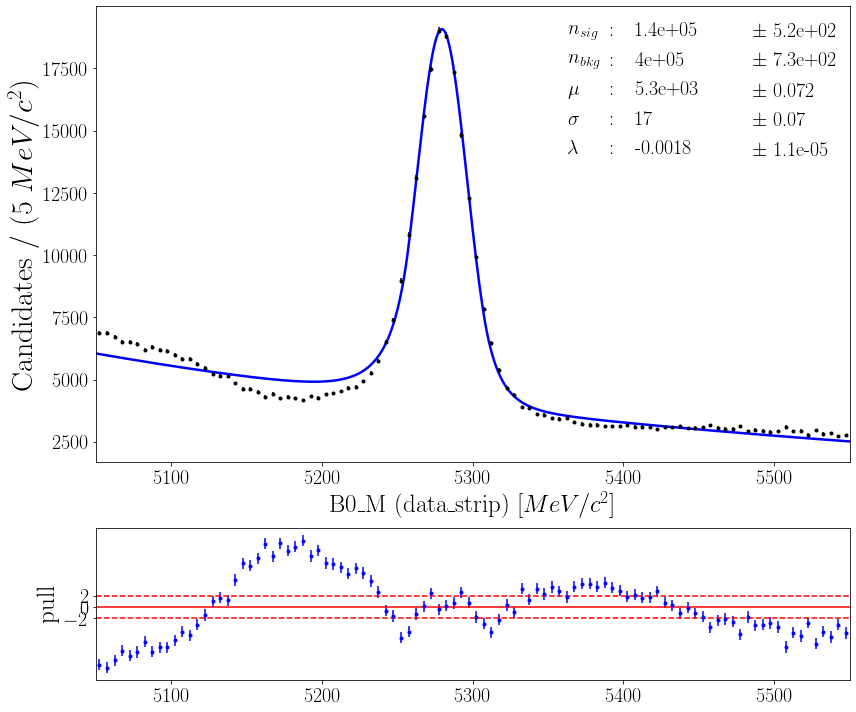

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/data_strip_cutDeltaM/B0_M_data\_strip_fit.pdf


In [15]:
plot_hist_fit(df_data_strip,'B0_M','$MeV/c^2$',models=model1, obs=obs, n_bins = 100,mode_hist = False,
              name_folder = 'data_strip_cutDeltaM',name_data = 'data\_strip',
              params=params1,name_params=name_params1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


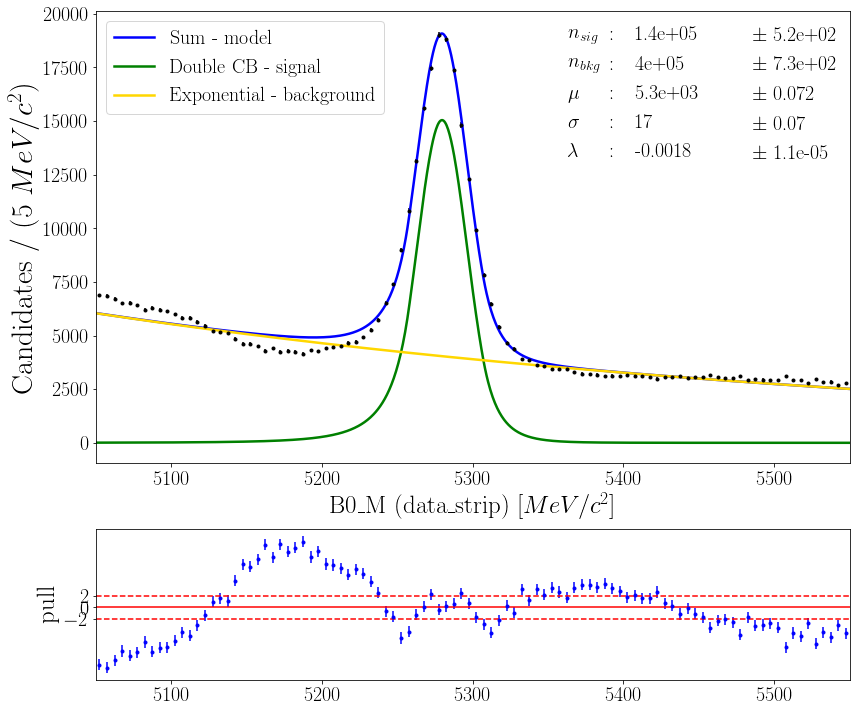

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/data_strip_cutDeltaM/B0_M_data\_strip_fit.pdf


In [17]:
plot_hist_fit(df_data_strip,'B0_M','$MeV/c^2$',
              models=[model1,doubleCB_ext1,exp_ext1], 
              name_models = ['Sum - model', 
                             'Double CB - signal',
                            'Exponential - background'],
              obs=obs, n_bins = 100,mode_hist = False,
              name_folder = 'data_strip_cutDeltaM', name_data = 'data\_strip',
              params=params1, name_params=name_params1)

## Fitting - 2nd solution
- One exponential component
- One CB (Crystall ball PDF)
- A gaussian component to account for partially reconstructed decays such as $B^0 \to D^* \pi \pi \pi \pi^0$

In [18]:
low = 5050.
high = 5550.
obs = zfit.Space("x", limits=(low, high))

In [19]:
mu = zfit.Parameter("mu", MC_param_results['mu_MC'], 5275., 5285.)
sigma = zfit.Parameter("sigma", 20., 10., 30.)
alphaL = zfit.Parameter("alphaL", MC_param_results['alphaL_MC'], floating=False)
alphaR = zfit.Parameter("alphaR", MC_param_results['alphaR_MC'], floating=False)
nL = zfit.Parameter("nL", MC_param_results['nL_MC'], floating=False)
nR = zfit.Parameter("nR", MC_param_results['nR_MC'], floating=False)

In [20]:
n_bkg = zfit.Parameter('n_bkg', 402000,0,136500+402200)
n_sig = zfit.Parameter('n_sig', 136000,0,136500+402200)

In [21]:
#lambd = zfit.Parameter("lambda", -0.002, -1, -0.0001)
lambd = zfit.Parameter("lambda", -0.0009, -0.01, -0.0001)

In [22]:
mu2 = zfit.Parameter("mu2", 5000, 5000, 5150)
sigma2 = zfit.Parameter("sigma2", 40., 5., 80.)

In [23]:
n_bkg2 = zfit.Parameter('n_bkg2', 1000,0,(136500+402200)/10)

In [24]:
name_params ={
    'mu':'$\mu$',
    'sigma':'$\sigma$',
    'alphaL':'$\\alpha_L$',
    'alphaR':'$\\alpha_R$',
    'nL':'$n_L$',
    'nR':'$n_R$',
    'n_bkg':'$n_{bkg}$',
    'n_sig':'$n_{sig}$',
    'lambda':'$\\lambda$',
    'mu2':'$\\mu_2$',
    'sigma2':'$\\sigma_2$',
    'n_bkg2':'$n_{bkg2}$',
}

In [25]:
doubleCB = zfit.pdf.DoubleCB(mu, sigma, alphaL, alphaR, nL, nR, obs=obs)
exponential = zfit.pdf.Exponential(lambd, obs=obs)
gaussian = zfit.pdf.Gauss(mu2,sigma2,obs=obs)

# sum of the two PDFs
doubleCB_ext = doubleCB.create_extended(n_sig)
exp_ext = exponential.create_extended(n_bkg)
gaussian_ext = gaussian.create_extended(n_bkg2)
model = zfit.pdf.SumPDF([doubleCB_ext, exp_ext,gaussian_ext]) # gauss is folded by frac

In [26]:
data = zfit.Data.from_pandas(df_data_strip['B0_M'],obs=obs)
result, params = launch_fit(model, data, extended=True)

------------------------------------------------------------------
| FCN = -3.313e+06              |     Ncalls=459 (459 total)     |
| EDM = 0.00284 (Goal: 0.001)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse         minuit_minos    at limit
------  ----------  --------------  -------------------  ----------
n_sig       149200     +/- 6.5e+02  -7.5e+02   +6.5e+02     

Info: VariableMetricBuilder: no improvement in line search
Info: VariableMetricBuilder: machine accuracy limits further improvement.
Info: VariableMetricBuilder: Stop the minimization - reached machine accuracy limit
Info in Edm is smaller than machine accuracy : machineLimit = 0.197484
Info in Current  Edm is : edm = 0.0028376
Info in Required Edm is : edmval = 0.001


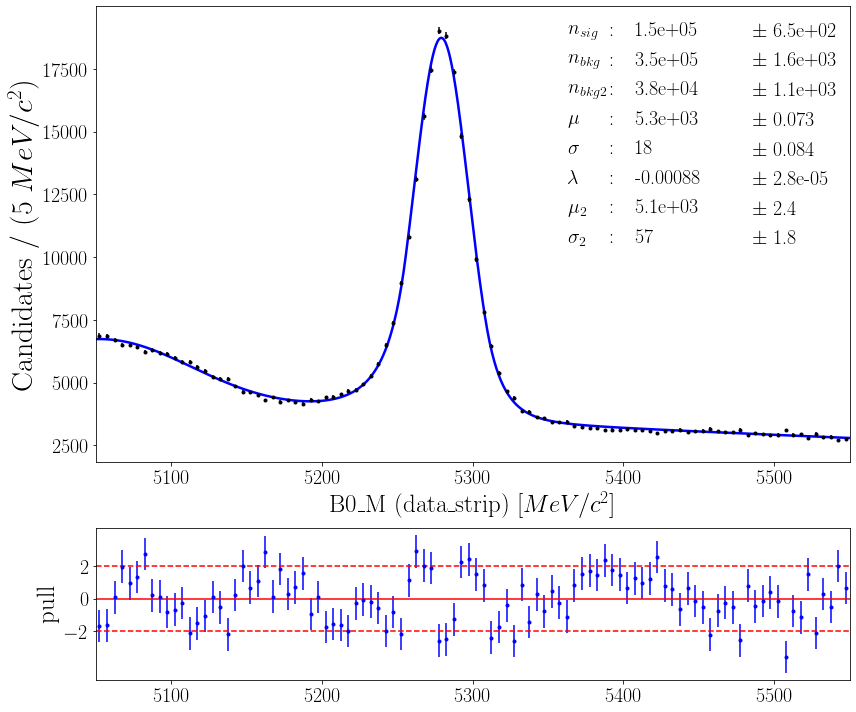

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/data_strip_cutDeltaM/B0_M_data\_strip_fit.pdf


In [27]:
plot_hist_fit(df_data_strip,'B0_M','$MeV/c^2$',models = model, obs=obs, n_bins = 100,mode_hist = False,
              name_folder = 'data_strip_cutDeltaM',name_data = 'data\_strip',
              params=params,name_params=name_params)

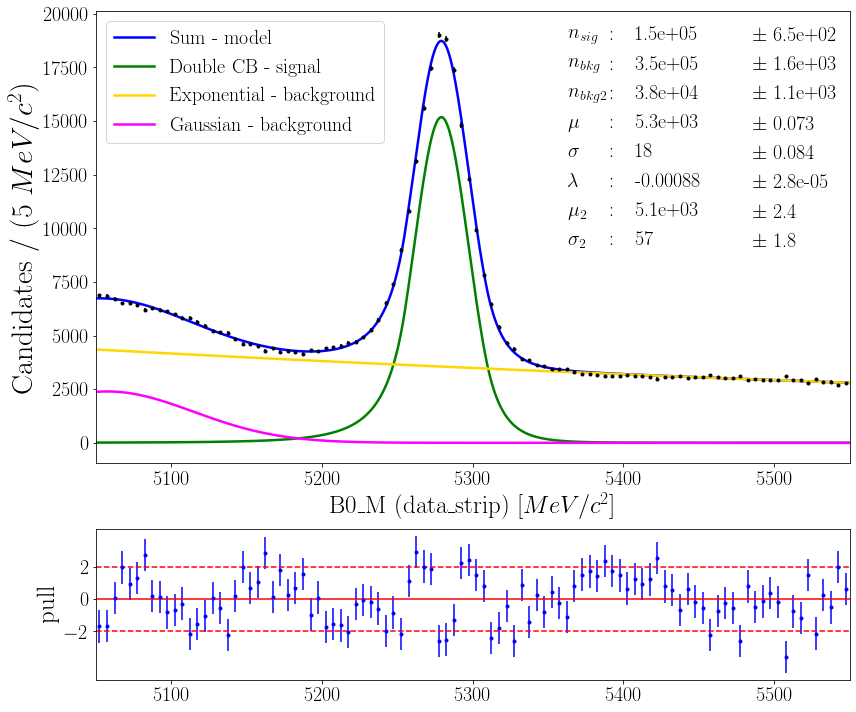

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/data_strip_cutDeltaM/B0_M_data\_strip_fit.pdf


In [28]:
plot_hist_fit(df_data_strip,'B0_M','$MeV/c^2$',models = [model,doubleCB_ext,exp_ext,gaussian_ext], 
              obs=obs, n_bins = 100,mode_hist = False, name_models = ['Sum - model', 'Double CB - signal',
                                                                      'Exponential - background', 
                                                                      'Gaussian  - background'],
              name_folder = 'data_strip_cutDeltaM',name_data = 'data\_strip',
              params=params,name_params=name_params)

## Fitting BUT with a cut on the BDT distribution
- One exponential component
- One CB (Crystall ball PDF)
- A gaussian component to account for partially reconstructed decays such as $B^0 \to D^* \pi \pi \pi \pi^0$

### BDT distribution

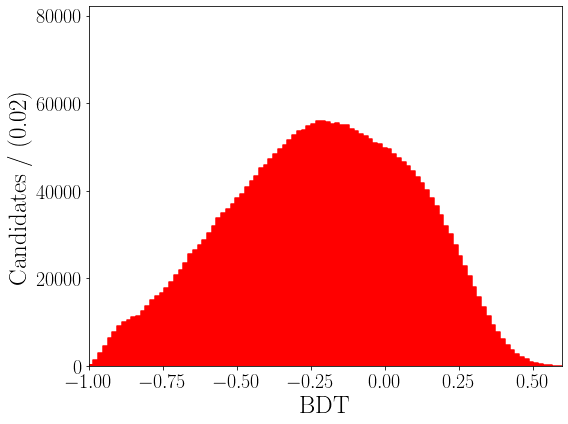

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/adaboost_0.8_without_P_cutDeltaM/BDT_adaboost_0.8_without_P_cutDeltaM.pdf


In [11]:
name_BDT = 'adaboost_0.8_without_P_cutDeltaM'
fct.plot_hist({name_BDT:df_data_strip},'BDT', 'BDT', '', n_bins = 100, mode_hist = True, name_folder = name_BDT)

We cut out the events that has BDT < -0.5

In [7]:
df_data_strip_cut = df_data_strip.query("BDT > -0.5")

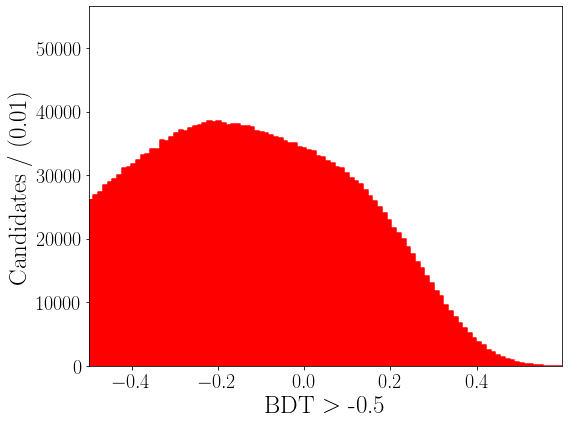

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/adaboost_0.8_without_P_cutDeltaM/BDT > -0.5.pdf


In [12]:
name_BDT = 'adaboost_0.8_without_P_cutDeltaM'
fct.plot_hist({name_BDT:df_data_strip_cut},'BDT', 'BDT $>$ -0.5', '', n_bins = 100, mode_hist = True, 
              name_folder = name_BDT, name_file = 'BDT > -0.5')

In [13]:
low = 5050.
high = 5550.
obs = zfit.Space("x", limits=(low, high))

In [14]:
mu = zfit.Parameter("mu", MC_param_results['mu_MC'], 5275., 5285.)
sigma = zfit.Parameter("sigma", MC_param_results['sigma_MC'], 10., 30.)
alphaL = zfit.Parameter("alphaL", MC_param_results['alphaL_MC'], floating=False)
alphaR = zfit.Parameter("alphaR", MC_param_results['alphaR_MC'], floating=False)
nL = zfit.Parameter("nL", MC_param_results['nL_MC'], floating=False)
nR = zfit.Parameter("nR", MC_param_results['nR_MC'], floating=False)

In [15]:
n_bkg = zfit.Parameter('n_bkg', 402000,0,136500+402200)
n_sig = zfit.Parameter('n_sig', 136000,0,136500+402200)

In [16]:
lambd = zfit.Parameter("lambda", -0.0009, -0.01, -0.0001)
mu2 = zfit.Parameter("mu2", 5000, 5000, 5150)
sigma2 = zfit.Parameter("sigma2", 40., 5., 80.)

In [17]:
n_bkg2 = zfit.Parameter('n_bkg2', 1000,0,(136500+402200)/10)

In [18]:
name_params ={
    'mu':'$\mu$',
    'sigma':'$\sigma$',
    'alphaL':'$\\alpha_L$',
    'alphaR':'$\\alpha_R$',
    'nL':'$n_L$',
    'nR':'$n_R$',
    'n_bkg':'$n_{bkg}$',
    'n_sig':'$n_{sig}$',
    'lambda':'$\\lambda$',
    'mu2':'$\\mu_2$',
    'sigma2':'$\\sigma_2$',
    'n_bkg2':'$n_{bkg2}$',
}

In [19]:
doubleCB = zfit.pdf.DoubleCB(mu, sigma, alphaL, alphaR, nL, nR, obs=obs)
exponential = zfit.pdf.Exponential(lambd, obs=obs)
gaussian = zfit.pdf.Gauss(mu2,sigma2,obs=obs)

# sum of the two PDFs
doubleCB_ext = doubleCB.create_extended(n_sig)
exp_ext = exponential.create_extended(n_bkg)
gaussian_ext = gaussian.create_extended(n_bkg2)
model = zfit.pdf.SumPDF([doubleCB_ext, exp_ext,gaussian_ext]) # gauss is folded by frac

In [32]:
data = zfit.Data.from_pandas(df_data_strip_cut['B0_M'],obs=obs)
result, params = launch_fit(model, data, extended=True)

------------------------------------------------------------------
| FCN = -2.579e+06              |     Ncalls=123 (123 total)     |
| EDM = 0.00197 (Goal: 0.001)   |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse         minuit_minos    at limit
------  ----------  --------------  -------------------  ----------
n_sig       146800     +/- 6.4e+02  -6.7e+02   +6.4e+02     

Info: VariableMetricBuilder: Stop the minimization - reached machine accuracy limit
Info in Edm is smaller than machine accuracy : machineLimit = 0.153709
Info in Current  Edm is : edm = 0.00196659
Info in Required Edm is : edmval = 0.001


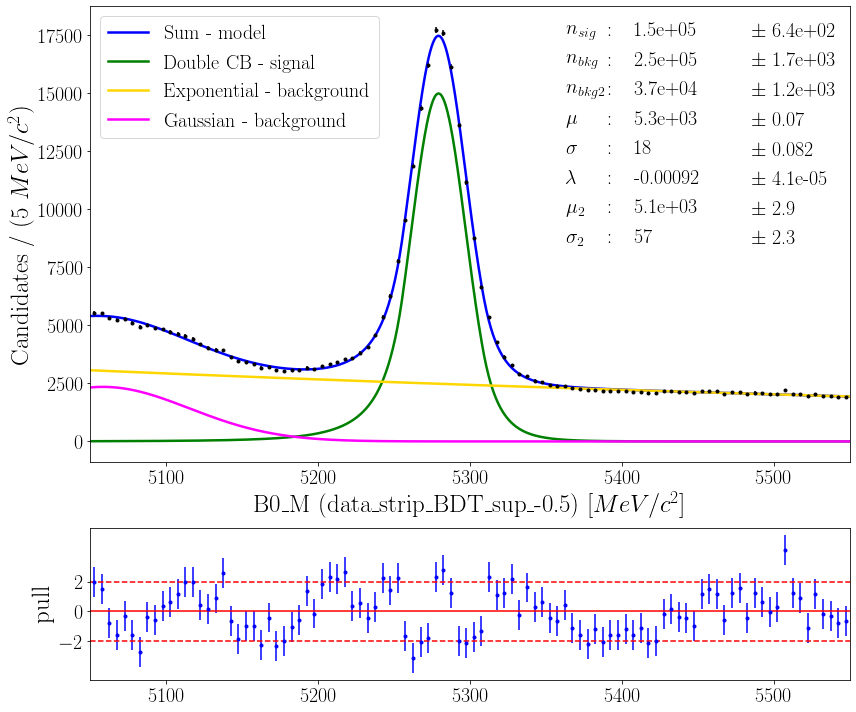

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/data_strip_cutDeltaM/B0_M_data\_strip\_BDT\_sup\_-0.5_fit.pdf


In [33]:
plot_hist_fit(df_data_strip_cut,'B0_M','$MeV/c^2$',models = [model,doubleCB_ext,exp_ext,gaussian_ext], 
              obs=obs, n_bins = 100,mode_hist = False, name_models = ['Sum - model', 'Double CB - signal',
                                                                      'Exponential - background', 
                                                                      'Gaussian  - background'],
              name_folder = 'data_strip_cutDeltaM',name_data = 'data\_strip\_BDT\_sup\_-0.5',
              params=params,name_params=name_params)